- Autoregressive
- Unserpervised Learning

Give a text sample-
- Extract input blocks as subsamples that serve as input to the LLM
- LLM prediction task is to predict the next token in the sequence that would follow the input block
- During training, we mask out all the all the tokens that are past the target token

# Creating Input-Target Pairs

Implement Datalaoder that fetches input-target pairs using a sliding window approach

In [3]:
# Encode using BPE tokenizer
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
with open("the-verdict.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()

encoded_text = tokenizer.encode(raw_text)

print(len(encoded_text))


5145


In [6]:
# REmove first 50 tokens from the encoded text
encoded_sample = encoded_text[50:]

One of the most intuitive ways to create input-target pairs is to create two variables x and y.
- x contains the input tokens
- y contains the target token, which are inputs shifted by one position to the right

Context size contains the number of tokens in the input block





In [10]:
context_size = 4 #length of the input block

x = encoded_sample[:context_size]
y = encoded_sample[1:context_size+1]

print(f"Input: {x}")
print(f"Target:     {y}")

Input: [290, 4920, 2241, 287]
Target:     [4920, 2241, 287, 257]


In [17]:
for i in range(1, context_size+1):
    context = encoded_sample[:i]
    target = encoded_sample[i]
    print(f"{context} --> {target}")

# Everything left of the arrow is the input tokens to the LLM, and everything right of the arrow is the target token LLM is trying to predict


[290] --> 4920
[290, 4920] --> 2241
[290, 4920, 2241] --> 287
[290, 4920, 2241, 287] --> 257


In [19]:
for i in range(1, context_size+1):
    context = encoded_sample[:i]
    target = encoded_sample[i]

    print(f"{tokenizer.decode(context)} --> {tokenizer.decode([target])}")


 and -->  established
 and established -->  himself
 and established himself -->  in
 and established himself in -->  a


## Implementing the DataLoader

Need to imlement Dataloader that contains input output tensors

Since the context size is 4, in eacg input-output pair there are 4 predicted tasks

**Input Tensor**
- We collect inputs in a tensor x, where each row represents an input context
- In input tensor, each row represents first words, with next row representing the next 4 words if the entire input context

**Output Tensor**
- In tensor y conatins the correxponding prediction shifted by one position to the right
- In output tensor, each row represents input tensors shifted by one position to the right


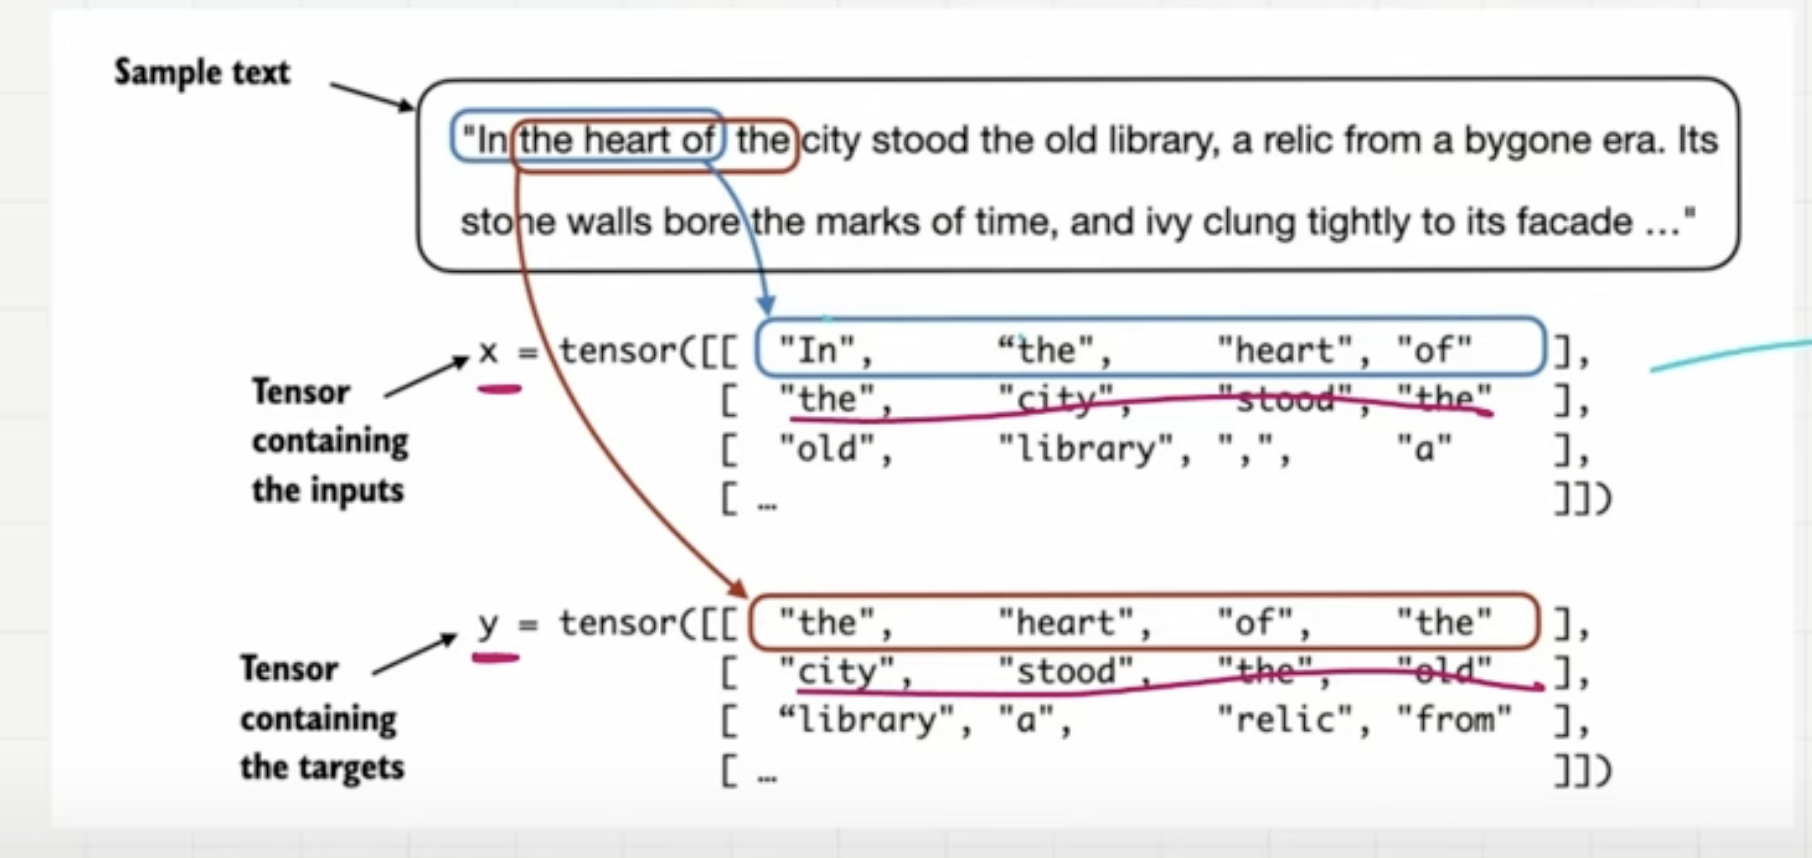

In [32]:
from torch.utils.data import DataLoader, Dataset

# max_length -is the context size
# stride - is the number of tokens to shift the input context by to create the next input-output pair
class GPTDatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i  :  i + max_length]
            target_chunk = token_ids[i + 1  :  i + max_length +1]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


- Step 1: Initialize the tokenizer
- Step 2: Create the dataset
- Step 3: drop_last=True - drop the last batch if it is shorter then the specified batch_size to prevent loss spikes during training
- Step 4: The number of CPU processess to use for processing the data



In [33]:
def create_dataset_v1(text, batch_size = 4, max_length = 256, stride = 128, shuffle = True, drop_last = True, num_workers = 0): 

    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = GPTDatasetV1(text, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader





Lets test the dataloader, with batch size of 1 and context size of 4, to develop intuition of how GPTDatasetV1 class and create_dataset_v1 function works together


In [34]:
with open("the-verdict.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()


In [39]:
import torch

print("PyTorch Version:", torch.__version__)

dataloader = create_dataset_v1(raw_text, batch_size=1, max_length=4, stride=2, shuffle=False)

data_iter = iter(dataloader)
first_batch = next(data_iter)

input_ids, target_ids = first_batch

print("Input IDs:", input_ids)
print("Target IDs:", target_ids)


PyTorch Version: 2.5.1
Input IDs: tensor([[  40,  367, 2885, 1464]])
Target IDs: tensor([[ 367, 2885, 1464, 1807]])


In [40]:
second_batch = next(data_iter)

input_ids, target_ids = second_batch

print("Input IDs:", input_ids)
print("Target IDs:", target_ids)

Input IDs: tensor([[2885, 1464, 1807, 3619]])
Target IDs: tensor([[1464, 1807, 3619,  402]])


Batch size is the number of input-output pairs in each batch that model has to process before updating the weights

If the batch size is very small, the updates will be very frequent, which can lead to unstable training, since updates is noisy

If the batch size is very large, the updates will be less frequent, which can lead to updates being less noisy, but will take longer to converge

**Note** - Batch size is a hyperparameter that needs to be tuned for each specific task and model architecture

Using batch size 8 and stride 4, (stride) - to cover the entire text, without overlap as that might cause overfitting



In [41]:
data_loader = create_dataset_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(data_loader)

first_batch = next(data_iter)

input_ids, target_ids = first_batch

print("Input IDs:", input_ids)
print("Target IDs:", target_ids)


Input IDs: tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Target IDs: tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])
